### About the notebook

GoBig part upscales the model trained in the SegmentationLearner notebook. Make sure the loaded model names match (they should if you left the default ones).
- TODO:
Better refactor code so that each notebook run would be an Upscaling step, instead of all upscaling in a loop. This way would be able to instpect metrics better without sacrificing speed.

### Constants
Pick the depending on the machine you use to train and personal preferences.

- ```batchsize``` sets how big a single train batch was in the small version. It should scale down proportionaly dependong on your res, default = 64 (fits well for 11G graphics card and input pic resolution 64x64)
- ```use_transfer``` sets if we use transfer learning or not. Default is False, because unrealistic scenes in Unity are trained not very good.
For real life applications try to make as realistic of a scene as possible (lighting, shaddows, ambient lights, textures, etc.)
- ```input_res``` and ```output_res```
Increased resolution transfer sizes, they will always be square, so one dimention is enough.
Input aspect ratio and resolution doesn't too matter much, they are squished into square before learning and unsquished afterwards. Should keep that in mind when applying in an actual use case though. Both axes must bigger than maximum defined size in output_res.
Default level training is always (64,64). If output_res is empty same size as input_res, no transfer learning to increase resolution can be done.
- ```model_arch```
How deep your network is. My 11 gig card handles resnet34 well, asuming batchsize = 80 with pic size = (64,64). If you have more capable hardware (or use cloud computing), you can try go higher.

In [1]:
use_transfer = False
input_res = 256
output_res = 512
from fastai.vision.all import resnet34 as model_arch
big_epochs = 20 #5
save_name = "unity_resnet34"

batchsize = 256 // ((output_res // 64) ** 2)# - ( pic_size // 64) # a double // makes this int type. Uncomment if bs too big for CUDA
#batchsize = 5 #override if still have problems

other choices include: resnet50, resnet101, etc. More info at: https://docs.fast.ai/vision.models.xresnet.html and 
https://fastai1.fast.ai/vision.models.html

In [2]:
print("Final batchsize: ", str(batchsize))

Final batchsize:  4


# Upscale

#### Helper Funcs

In [3]:
from fastai.learner import patch, delegates, subplots, Recorder
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd
from fastinference.onnx import *
#Source: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

### Interpetation

So the whole idea by going bigger is to transfer what our model already learned and train a network with more outputs on top of it. If there are memory problems, try restarting the kernel, then run "constants" cell and then continue form here. If it still does not work, try reducing params, like batchsize, resolutions, etc.

In [4]:
from fastai.vision.all import PILImage, get_image_files, DataBlock, unet_learner, ImageBlock, MaskBlock, RandomSplitter, aug_transforms, foreground_acc, DiceMulti,Normalize
from fastai.vision.all import SegmentationInterpretation
import os, pathlib
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")
fnames = get_image_files(os.path.join(path,"screenshots"))
base_img = PILImage.create(fnames[0])

In [5]:
codes = pd.read_csv(os.path.join(path,'labels.csv'))

In [6]:
#testing if resolutions fit:
if output_res > min(base_img.shape):
    raise Exception("Sorry, but your input screenshot is not higher resolution than your defined 'output_res' value. It must either match or be smaller than screen.")

In [7]:
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")

In [8]:
def train_bigger(epochs, lr, model_name_load, model_name_save, pic_size, do_final_export):
    current_size = (pic_size,pic_size)
    print("current pic size:",current_size)
    print("current batchsize:",batchsize)
    print("epochs:",epochs)
    bigger_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes.LabelName)),
                       get_items = get_image_files,
                       get_y = label_func,
                       splitter=RandomSplitter(),
                       batch_tfms=[*aug_transforms(flip_vert = False, max_lighting = 0.1, max_warp=0.05, size=current_size), Normalize])
    dls = bigger_block.dataloaders(os.path.join(path,"screenshots"), path=path, bs=batchsize)
    learn = unet_learner(dls, model_arch, pretrained = use_transfer, moms=(0.85, 0.75, 0.85), n_out=len(codes["LabelName"])+1, metrics=[foreground_acc, DiceMulti()])
    learn.load(model_name_load)
    learn.fit_one_cycle(epochs, lr)

    learn.save(model_name_save)

    if do_final_export:
        learn.export("models/"+model_name_save+"_big")
        print("exported final model as:",model_name_save+"_big")

        onnx_path = os.path.join(path, "models/", model_name_save+"_onnx")
        learn.to_onnx(onnx_path)
        print("exported an onnx model as:",onnx_path)
    return learn

In [9]:
lr = slice(5e-6, 3e-5)
lr

slice(5e-06, 3e-05, None)

In [10]:
name_to_load = save_name+"_"+str(input_res)+"x"
name_to_save = save_name+"_"+str(output_res)+"x"

print("Training: "+name_to_save)
learner = train_bigger(big_epochs, lr, name_to_load, name_to_save, output_res, True)

Training: unity_resnet34_512x
current pic size: (512, 512)
current batchsize: 4
epochs: 20


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.356633,0.082558,0.975720,0.847042,04:56
1,0.283801,0.074809,0.977554,0.850777,04:54
2,0.190761,0.070570,0.979172,0.853131,04:53
3,0.210830,0.081655,0.975331,0.851070,04:53
4,0.187588,0.078220,0.975617,0.847205,04:54
5,0.165381,0.084511,0.975109,0.812546,04:54
6,0.133584,0.134525,0.963105,0.853454,04:53
7,0.131018,0.066597,0.979100,0.870908,04:54
8,0.121324,0.069047,0.979190,0.854256,04:53
9,0.101652,0.062622,0.980797,0.860900,04:53


exported final model as: unity_resnet34_512x_big
exported an onnx model as: /home/carrotpie/code/classB/SegmentationLearner/Assets/Data~/models/unity_resnet34_512x_onnx


# Results

### Metrics

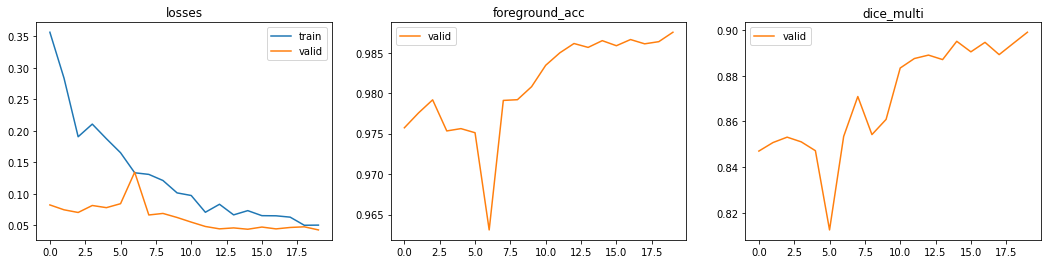

In [11]:
    #!!!! If you use metrics, the models seems to sometimes run out of memory, so decrease batch size before that.
#metrics
learner.recorder.plot_metrics()

In [ ]:
#top losses
interp = SegmentationInterpretation.from_learner(learner)
interp.plot_top_losses(k=5)

In [ ]:
raise Exception("Stop here. Below section should be run separately after kernel restart. Otherwise libs interfere with each other somehow. First run constants cell, then all of the below.")

## Predicting

### Loading libs and paths

In [ ]:
from fastai.learner import patch, delegates, subplots, Recorder, load_learner
import os, pathlib
from fastai.vision.all import PILImage, get_image_files
import numpy as np

from notebook_libs.helper_funcs import show_masked_original_size, path_to_image_bytes, load_image_from_bytes

def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")

In [ ]:
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data~")

In [ ]:
# Can use walk to read the folder or just import with a helper func:
_test_upload_file = ""
for root, dirs, files in os.walk(
    path, topdown=True, onerror=None, followlinks=False
):
    _test_upload_file = os.path.join(root, files[0])
model_path = os.path.join(path, "models", "unity_resnet34_"+str(output_res)+"x"+"_big")

fnames = get_image_files(os.path.join(path,"screenshots"))

print(model_path)
print(_test_upload_file)
print(fnames[0])

### Loading a model

In [ ]:
learner = load_learner(model_path)
img_bytes = path_to_image_bytes(_test_upload_file)
image = load_image_from_bytes(img_bytes)

### Predictions

In [ ]:
base_img = PILImage.create(fnames[0])
pred = learner.predict(np.array(base_img))[0]
print(pred.shape)
pred.show()

In [ ]:
show_masked_original_size(base_img, learner)

For ONNX inference / predictions, see ONNX.ipynb